In [1]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image

! pip install vit_keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16, EfficientNetV2L, ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import os
from vit_keras import vit, utils

  Obtaining dependency information for validators from https://files.pythonhosted.org/packages/3a/0c/785d317eea99c3739821718f118c70537639aa43f96bfa1d83a71f68eaf6/validators-0.22.0-py3-none-any.whl.metadata


/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


train_dir = '/kaggle/input/dogs-cats-images/dataset/training_set'
test_dir = '/kaggle/input/dogs-cats-images/dataset/test_set'

classes = os.listdir(train_dir)

resize_size = 256
crop_size = 224

def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR)
    image = tf.image.central_crop(image, central_fraction=crop_size / resize_size)
    image = tf.math.divide(image, 255.0)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std

    return image

def resize_and_crop(image, resize_size=256, crop_size=224):
    # Resize with bilinear interpolation
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR)
    cropped_image = tf.image.central_crop(resized_image, central_fraction=crop_size / resize_size)
    image = tf.math.divide(cropped_image, 255.0) #normalize

    return image

def preprocess_for_attack(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std #다 normalize

    return image

X = []
Original_X = []
y = []
for i in classes:
    for directory in [train_dir, test_dir]:
        folderPath = os.path.join(directory,i)
        for j in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath,j))
            O_img = resize_and_crop(img)
            Original_X.append(O_img)
            img = preprocess_image(img) #전처리
            X.append(img) #X list 넣고
            y.append(i) 
            
#X = np.array(X)
#y = np.array(y)
y = tf.keras.utils.to_categorical([classes.index(label) for label in y])
#Original_X = np.array(Original_X)

100%|██████████| 1000/1000 [00:22<00:00, 43.95it/s]


In [3]:
from keras.models import load_model

model = load_model('/kaggle/input/models/vgg_best_model.h5')
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
#model_reset = load_model('/kaggle/input/models/resnet_best_model.h5')

#y_pred_test = model_vgg.predict(X_test)
#right_predictions = (y_pred_test.argmax(axis=1) == y_test.argmax(axis = 1))
#print('Right predictions:', sum(right_predictions))

In [4]:
#y = tf.keras.utils.to_categorical([classes.index(label) for label in y])

_,xx,_,yy = train_test_split(X, y, test_size=0.2,random_state=42)
_,X_test,_,y_test = train_test_split(xx, yy, test_size=0.5,random_state=42)
del X

Original_X = np.array(Original_X)
_,xx_og,_,yy_og = train_test_split(Original_X, y, test_size=0.2,random_state=42)
_,X_test_og,_,y_test_og = train_test_split(xx_og, yy_og, test_size=0.5,random_state=42)

del Original_X
del y

In [5]:
import copy
import numpy as np
import tensorflow as tf
from skimage import color


def deepfool(image, model, num_classes=2, overshoot=0.02, max_iter=50, shape=(224, 224, 3)):
    #image = preprocess_image(image)
    #image_array = np.array(image)
    #print(np.shape(image_array)) # 28*28

    
    #image_norm = tf.cast(image_array - 0.5, tf.float32)
    #image_norm = np.reshape(image_norm, shape)  # 28*28*1
    #image_norm = image_norm[tf.newaxis, ...]  # 1*28*28*1
    
    image_norm = preprocess_for_attack(image)

    f_image = model(image_norm).numpy().flatten()
    I = (np.array(f_image)).flatten().argsort()[::-1]
    I = I[0:num_classes]
    label = I[0]
    # print(label, "label")

    input_shape = np.shape(image_norm)
    pert_image = copy.deepcopy(image)
    w = np.zeros(input_shape)
    r_tot = np.zeros(input_shape)

    loop_i = 0
    x = tf.Variable(pert_image)
    fs = model(preprocess_for_attack(x))
    k_i = label

    #print(fs)  # shape=(1, 10)

    def loss_func(logits, I, k):
        # return tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        return logits[0, I[k]]

    while k_i == label and loop_i < max_iter:

        pert = np.inf

        one_hot_label_0 = tf.one_hot(label, num_classes)
        with tf.GradientTape() as tape:
            tape.watch(x)
            fs = model(preprocess_for_attack(x))
            # loss_value = loss_func(one_hot_label_0, fs)
            loss_value = loss_func(fs, I, 0)
        # grad_orig = tape.gradient(fs[0, I[0]], x)
        grad_orig = tape.gradient(loss_value, x)

        for k in range(1, num_classes):
            one_hot_label_k = tf.one_hot(I[k], num_classes)
            with tf.GradientTape() as tape:
                tape.watch(x)
                fs = model(x)
                # loss_value = loss_func(one_hot_label_k, fs)
                loss_value = loss_func(fs, I, k)
            # cur_grad = tape.gradient(fs[0, I[k]], x)
            cur_grad = tape.gradient(loss_value, x)

            w_k = cur_grad - grad_orig

            f_k = (fs[0, I[k]] - fs[0, I[0]]).numpy()

            pert_k = abs(f_k) / np.linalg.norm(tf.reshape(w_k, [-1]))

            if pert_k < pert:
                pert = pert_k
                w = w_k

        # print(pert)  # 1.3409956
        # print(np.shape(w))  # (1, 28, 28, 1)
        r_i = (pert + 1e-4) * w / np.linalg.norm(w)
        r_tot = np.float32(r_tot + r_i)

        pert_image = image + (1 + overshoot) * r_tot

        x = tf.Variable(pert_image)

        fs = model(preprocess_for_attack(x))
        k_i = np.argmax(np.array(fs).flatten())

        loop_i += 1

    r_tot = (1 + overshoot) * r_tot

    return r_tot, loop_i, label, k_i, pert_image, f_image

In [6]:
import numpy as np
import tensorflow as tf
from PIL import Image


def test_deepfool(image_to_be_perturbed, model):
    image = image_to_be_perturbed
    model = model

    r, loop_i, label_orig, label_pert, pert_image, f_image = deepfool(image, model)
    #print("label_orig: ", label_orig)
    #print("label_pert: ", label_pert)
    pert_image = np.reshape(pert_image, (224, 224, 3))

    #pert_image += 0.5
    #pert_image *= 255

    return pert_image, label_pert
  

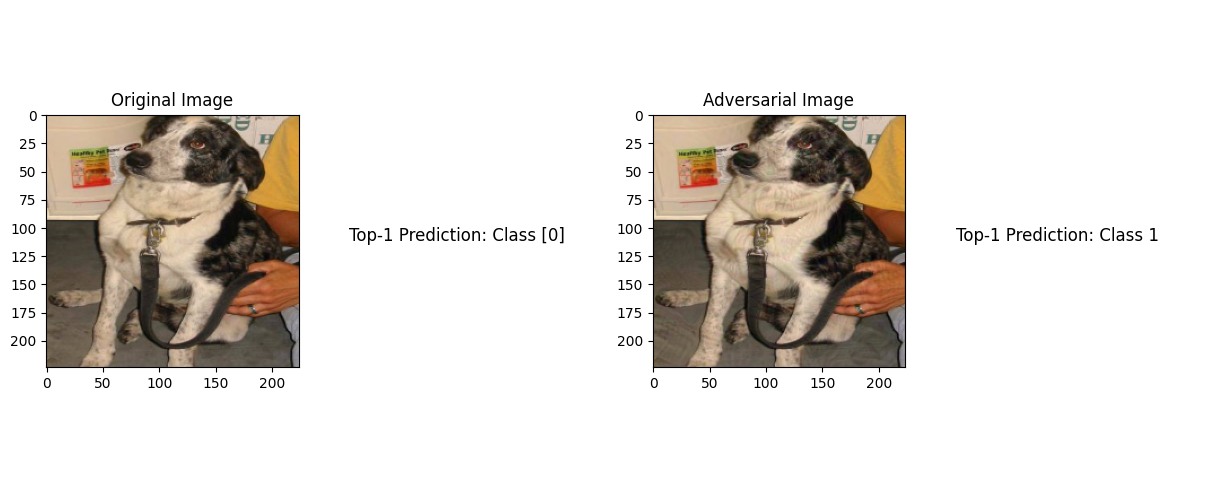

In [7]:
# Load the model
#preprocess_input = tf.keras.applications.vgg16.preprocess_input

index_to_use = 2
image = X_test_og[22]
image = tf.expand_dims(image, axis=0)  # Add batch dimension
label = np.argmax(y_test_og[index_to_use])

# Model prediction on original image
original_prediction = model(preprocess_for_attack(image))

# iFGSM attack
adv_image, adv_prediction = test_deepfool(image, model)

# Extract top-1 predictions
original_top1_class = tf.argmax(original_prediction, axis=1)[0:5]
adv_top1_class = adv_prediction #tf.argmax(adv_prediction, axis=1)[0:5]

# Display the results
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.imshow(image.numpy().squeeze())
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.text(0, 0.5, f'Top-1 Prediction: Class {original_top1_class}', fontsize=12)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(adv_image.squeeze())
plt.title('Adversarial Image')

plt.subplot(1, 4, 4)
plt.text(0, 0.5, f'Top-1 Prediction: Class {adv_top1_class}', fontsize=12)
plt.axis('off')

plt.show()

In [8]:
deepfool_images = []
for i in tqdm(range(10)):
    p, _ = test_deepfool(np.array(X_test_og[i]).reshape(1, 224, 224, 3), model)
    deepfool_images.append(p)

100%|██████████| 10/10 [00:54<00:00,  5.48s/it]


In [11]:
y_pred = model.predict(np.array(X_test[:10]))
y_pred_single_label = np.argmax(y_pred[:10], axis=1)
y_test_single_label = np.argmax(y_test[:10], axis=1)

from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test_single_label, y_pred_single_label, average='macro')
recall = recall_score(y_test_single_label, y_pred_single_label, average='macro')
f1 = f1_score(y_test_single_label, y_pred_single_label, average='macro')
accuracy = accuracy_score(y_test_single_label, y_pred_single_label)
precision = round(precision, 3)
recall = round(recall, 3)
f1 = round(f1, 3)
accuracy = round(accuracy, 3)
print(precision, recall, f1, accuracy)

1/1 [==============================] - 3s 3s/step
1.0 1.0 1.0 1.0


In [12]:
y_pred_adv = model.predict(preprocess_for_attack(np.array(deepfool_images)))
y_pred_single_label = np.argmax(y_pred_adv, axis=1)
y_test_single_label = np.argmax(y_test_og[:10], axis=1)

precision = precision_score(y_test_single_label, y_pred_single_label, average='macro')
recall = recall_score(y_test_single_label, y_pred_single_label, average='macro')
f1 = f1_score(y_test_single_label, y_pred_single_label, average='macro')
accuracy = accuracy_score(y_test_single_label, y_pred_single_label)
precision = round(precision, 3)
recall = round(recall, 3)
f1 = round(f1, 3)
accuracy = round(accuracy, 3)
print(precision, recall, f1, accuracy)

1/1 [==============================] - 3s 3s/step
0.0 0.0 0.0 0.0


In [13]:
y_pred_single_label, y_test_single_label

(array([1, 1, 1, 1, 1, 0, 0, 1, 0, 0]), array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1]))

In [14]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

explainer = lime_image.LimeImageExplainer(random_state=42)

le = LabelEncoder(); 
le.fit_transform(classes)

array([1, 0])

In [17]:
import matplotlib.pyplot as plt
import cv2

def plot_images(original, temp, mask):
    
    #save_paths = [f'{model_name}/base_model/original/', f'{model_name}/base_model/superpixel/', f'{model_name}/base_model/pos_neg/']
    
    #for save_path in save_paths:
    #    if not os.path.exists(save_path):
    #        os.makedirs(save_path)

    plt.imshow(original)
    plt.axis('off')
    #plt.savefig(os.path.join(f'{model_name}/base_model/original/', f'{index_to_use}_predict:{predicted_class}_real:{real}.jpg'))
    
    
    # Lime이 생성한 이미지 표시 (temp)
    #plt.imshow(temp)
    #plt.set_title('Lime Image')
    #plt.axis('off')

    # Lime Mask를 원본 이미지에 적용하여 긍부정 시각화
    masked_positive = np.copy(original)
    masked_positive[mask <= 0] = 0  # 부정 부분은 검은색으로 설정
    
    plt.imshow(masked_positive)
    plt.axis('off')
    #plt.savefig(os.path.join(f'{model_name}/base_model/superpixel/', f'{index_to_use}_predict:{predicted_class}_real:{real}.jpg'))


    # Lime Mask를 원본 이미지에 적용하여 긍부정 시각화
    masked_negative = np.zeros_like(original)
    masked_negative[mask < 0] = [255, 0, 0]

    # Create a new image for positive parts (green color)
    masked_positive = np.zeros_like(original)
    masked_positive[mask > 0] = [0, 255, 0]

    # Combine the positive and negative images
    combined_image = original + masked_negative + masked_positive

    # Display the result with larger size
    plt.imshow(combined_image)
    plt.axis('off')
    #plt.savefig(os.path.join(f'{model_name}/base_model/pos_neg/', f'{index_to_use}_predict:{predicted_class}_real:{real}.jpg'))

    plt.show()

1/1 [==============================] - 0s 297ms/step
Predicted Class: 0
real class: 0


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


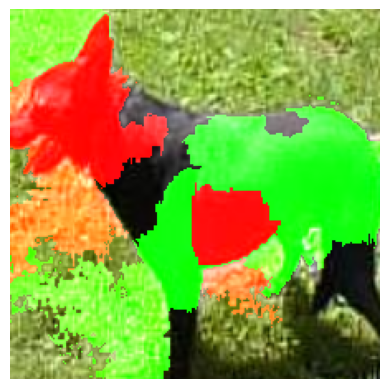

1/1 [==============================] - 0s 293ms/step
Predicted Class: 1
real class: 1


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


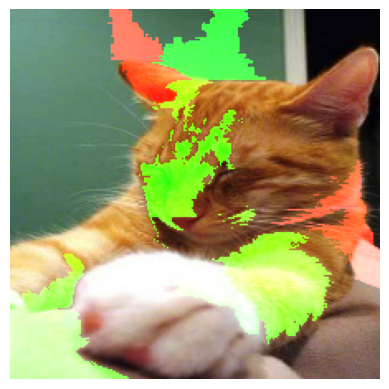

1/1 [==============================] - 0s 307ms/step
Predicted Class: 1
real class: 1


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


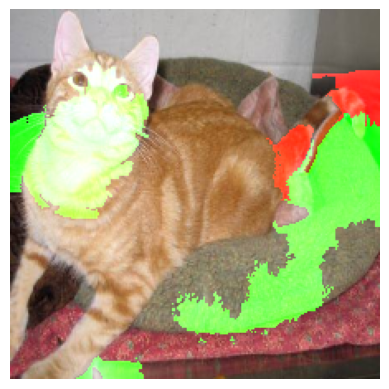

In [18]:
from lime.lime_image import LimeImageExplainer

for index_to_use in [3, 6, 9]:
    selected_image = X_test[:10][index_to_use]
    selected_image = np.expand_dims(selected_image, axis=0)
    prediction = model.predict(selected_image)
    predicted_class = np.argmax(prediction)
    real = np.argmax(y_test[:10][index_to_use])
    print("Predicted Class:", predicted_class)
    print("real class:", real)
    explainer = LimeImageExplainer(feature_selection='auto')
    explanation = explainer.explain_instance(selected_image[0], model.predict, top_labels=1, hide_color=0, num_samples=100)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plot_images(X_test_og[:10][index_to_use], temp, mask)

1/1 [==============================] - 0s 297ms/step
Predicted Class: 1
real class: 0


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


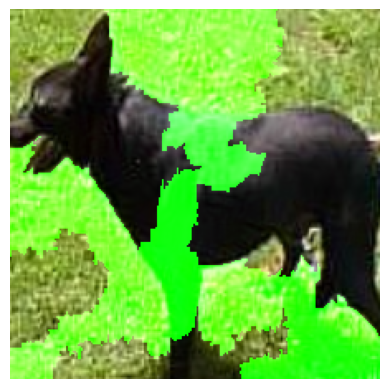

1/1 [==============================] - 0s 300ms/step
Predicted Class: 0
real class: 1


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


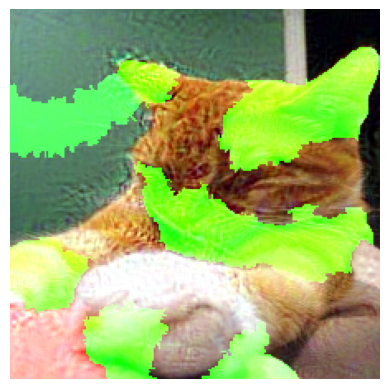

1/1 [==============================] - 0s 304ms/step
Predicted Class: 0
real class: 1


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


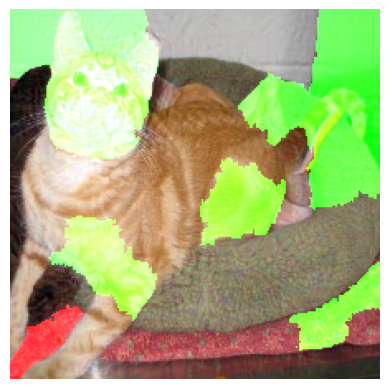

In [19]:
from lime.lime_image import LimeImageExplainer

for index_to_use in [3, 6, 9]:
    selected_image = deepfool_images[:10][index_to_use]
    selected_image = np.expand_dims(selected_image, axis=0)
    prediction = model.predict(preprocess_for_attack(selected_image))
    predicted_class = np.argmax(prediction)
    real = np.argmax(y_test[:10][index_to_use])
    print("Predicted Class:", predicted_class)
    print("real class:", real)
    explainer = LimeImageExplainer(feature_selection='auto')
    explanation = explainer.explain_instance(selected_image[0], model.predict, top_labels=1, hide_color=0, num_samples=100)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    plot_images(deepfool_images[:10][index_to_use], temp, mask)